In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.datasets import make_circles

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [2]:
# this is just code for building the animation
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
def animate_optimization(animation_data):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( -1, 1))
    ax.set_ylim((-1, 1))

    sct = ax.scatter([], [], lw=2)
    line, = ax.plot([], [])

    # initialization function: plot the background of each frame
    def init():
        sct.set_offsets([])
        line.set_data([], [])
        return (sct, line)

    # animation function.  This is called sequentially
    def animate(i):
        #fig = plt.figure()
        #ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

        data = animation_data[i][0]
        x = animation_data[i][1]
        y = animation_data[i][2]

        sct.set_offsets(data)
        sct.set_array(dev_labels)
        
        xmin, xmax = (-1, 1)
        p1 = (x[0], y[0])
        p2 = (x[1], y[1])
        if(p2[0] == p1[0]):
            xmin = xmax = p1[0]
            ymin, ymax = (-1, 1)
        else:
            ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
            ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

        line.set_data([xmin,xmax], [ymin,ymax])
        
        return sct, line
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(animation_data), interval=20, blit=True)

    return anim.to_jshtml()

In [6]:
# just code from the training loop,
# not really important
def training_loop(network, train_data, train_labels, dev_data, dev_label, lr=1e-1, batch_size = 200, n_epoch = 100):
    optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)
    #optimizer = torch.optim.Adam(network.parameters())

    animation_data = list()
    for _ in range(n_epoch):
        network.train()

        for i in range(0, train_data.shape[0], batch_size):
            optimizer.zero_grad()

            batch_data = train_data[i:i+batch_size]
            batch_labels = train_labels[i:i+batch_size]

            logits = network(batch_data).squeeze(1)
            loss = F.binary_cross_entropy_with_logits(
                            logits,
                            batch_labels.float(),
                            reduction="mean"
            )

            loss.backward()
            optimizer.step()

            # store data for animation
            with torch.no_grad():
                network.eval()

                data = network.hidden_proj(dev_data)
                y = torch.tensor([-1., 1.])
                #x_1 w_1 + x_2 w_2 + b = 0
                #x_1 = (-x_2 w_2 - b)/w_1
                x = -(
                    network.output_proj.weight[0, 1].item() * y
                    + network.output_proj.bias.item()) / network.output_proj.weight[0, 0].item()

                animation_data.append((
                    data.numpy(),
                    x,
                    y
                ))

        # dev eval
        with torch.no_grad():
            network.eval()
            pred = (network(dev_data).squeeze(1) > 0).float()
            accuracy = (pred == dev_labels).sum().item() / dev_data.shape[0]
    return animation_data

In [7]:
# Generate data
data, labels = make_circles(n_samples=2000, noise=0.1, random_state=1, factor=0.2)

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).long()

train_data = data[:-100]
train_labels = labels[:-100]
dev_data = data[-100:]
dev_labels = labels[-100:]

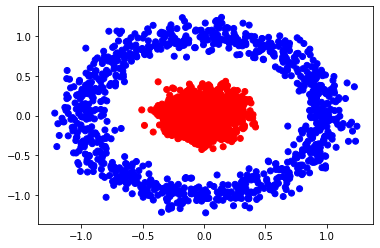

In [8]:
# the dataset has two class: red and blue
# and we want to build a classifier that can correctly predict the class of a new point

data_colors = np.array(["blue", "red"])
plt.scatter(train_data[:, 0], train_data[:, 1], c=data_colors[train_labels])
plt.show()

In [9]:
# Neural network
class Network(nn.Module):
    def __init__(self, deep=False):
        super().__init__()
        
        # there are two modes:
        # if deep is true, then it will be a deep neural network,
        # it deep is false, then it will be a linear classifier
        if deep:
            self.hidden_proj = nn.Sequential(
                nn.Linear(2, 50),
                nn.Tanh(),
                # here the dimension of is two so we can visualize points in the hidden space!
                nn.Linear(50, 2),
                nn.Tanh(),
            )
        else:
            self.hidden_proj = nn.Sequential()
        self.output_proj = nn.Linear(2, 1)
        
    def forward(self, data):
        return self.output_proj(self.hidden_proj(data))

In [11]:
# we first train a simple linear classifier
network = Network(deep=False)
animation_data = training_loop(network, train_data, train_labels, dev_data, dev_labels)

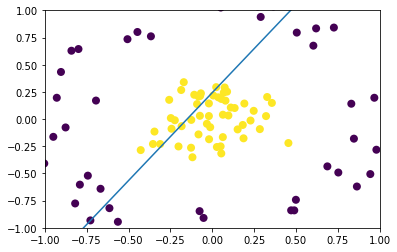

In [12]:
# as you can see in the animation,
# its not possible find a line that separate the two classes!
# best we can hope is to do 50% of errors
HTML(animate_optimization(animation_data[::10]))

In [13]:
# we now train a deep model
network = Network(deep=True)
animation_data = training_loop(network, train_data, train_labels, dev_data, dev_labels)

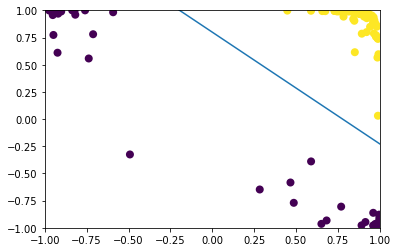

In [14]:
# Here what we are going to visualize is the output of the second projection
# as you see, the space is transformed so we can find a line that separates the two classes!
# this is deep learning :)
HTML(animate_optimization(animation_data[::10]))